In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import ot
import scipy.linalg as spl

In [2]:
def densite_theorique2d(mu,Sigma,alpha,x):
    # compute the 2D GMM density with parameters (mu, Sigma) and weights alpha at x
    K = mu.shape[0]
    alpha = alpha.reshape(1,K)
    y=0
    for j in range(K):
        y+=alpha[0,j]*sps.multivariate_normal.pdf(x,mean=mu[j,:],cov=Sigma[j,:,:])
    return y

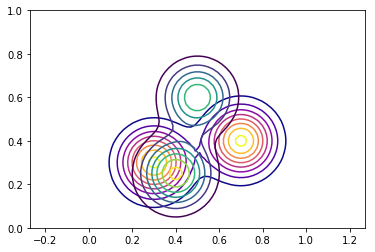

In [20]:
d  = 2 #space dimension

# 2D Gaussian mixtures
K0,K1 = 2,2
pi0 = np.array([[0.5,0.5]])
mu0 = np.array([[0.3,0.3],[0.7,0.4]])
S0 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])
pi1 = np.array([[0.45,0.55]])
mu1 = np.array([[0.5,0.6],[0.4,0.25]])
S1 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])

# display
n=50    
x = np.linspace(0, 1,num=n)
y = np.linspace(0, 1,num=n)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = densite_theorique2d(mu0,S0,pi0,XX)
Z = Z/Z.sum()
Z = Z.reshape(X.shape)
Z2 = densite_theorique2d(mu1,S1,pi1,XX,)
Z2 = Z2.reshape(X.shape)
Z2 = Z2/Z2.sum()
CS = plt.contour(X, Y, Z,8,cmap='plasma')
CS = plt.contour(X, Y, Z2,8,cmap='viridis')
plt.axis('equal');   

In [39]:
f1 = lambda S,pi: np.sqrt(2*np.sum([pi[0][i]*np.trace(S[i]) for i in range(S.shape[0])]))
f1(S0,pi0)+f1(S1,pi1)

0.4

In [21]:
def GaussianW2(m0,m1,Sigma0,Sigma1):
    '''compute the quadratic Wasserstein distance between two Gaussians 
    with means m0 and m1 and covariances Sigma0 and Sigma1
    
    Note: This also works between any two elliptic distributions !'''
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d

In [22]:
def GW2(pi0,pi1,mu0,mu1,S0,S1):
    '''return the GW2 discrete map and the GW2 distance between two GMM'''
    
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    C  = np.zeros((K0,K1))
    
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            C[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
            
            
    # Then we compute the OT distance or OT map thanks to the OT library (Kantorovich/EMD)
    P     = ot.emd(pi0,pi1,C)         # discrete transport plan
    distGW2   = np.sum(P*C)
    return P,distGW2

In [26]:
wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d),S1.reshape(K1,d,d))
wstar, dist

(array([[0.  , 0.5 ],
        [0.45, 0.05]]), 0.04787499999999999)

In [25]:
M = ot.dist(XX.reshape((n**2, 2)), XX.reshape((n**2, 2)))
M /= M.max()
G0 = ot.emd(Z.reshape(n**2), Z2.reshape(n**2), M)
dist2 = np.sum(G0*M)
G0, dist2

(array([[0.00000000e+00, 1.19357293e-07, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 0.01460015403019458)

In [40]:
print(dist-dist2)

0.03327484596980541


In [44]:
eps = [1,0.75,0.5,0.25,0.1]

for e in eps:
    wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d)*e,S1.reshape(K1,d,d)*e)
    print("MW",dist)
    
    
    M = ot.dist(XX.reshape((n**2, 2))*e, XX.reshape((n**2, 2))*e)
    M /= M.max()
    G0 = ot.emd(Z.reshape(n**2)*e, Z2.reshape(n**2)*e, M)
    dist2 = np.sum(G0*M)
    print("W", dist2)

MW 0.04787499999999999
W 0.01460015403019458
MW 0.04787499999999999
W 0.01095011552264595
MW 0.04787499999999999
W 0.00730007701509729
MW 0.04787499999999999
W 0.003650038507548645
MW 0.04787499999999999
W 0.001460015403019459


In [ ]:
# In 1 D 